In [4]:
"""
    This notebook is used to generate the figures for the following section:
    "Reachability and the Limits of Biophysically Plausible Compensation"
"""

'\n    This notebook is used to generate the figures for the following section:\n    "Reachability and the Limits of Biophysically Plausible Compensation"\n'

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

from da import simulate_individual_t_eval, get_default_u0, get_default_parameters
import warnings
from da import DICs
from tqdm import tqdm

# fix the seed for reproducibility
np.random.seed(42)

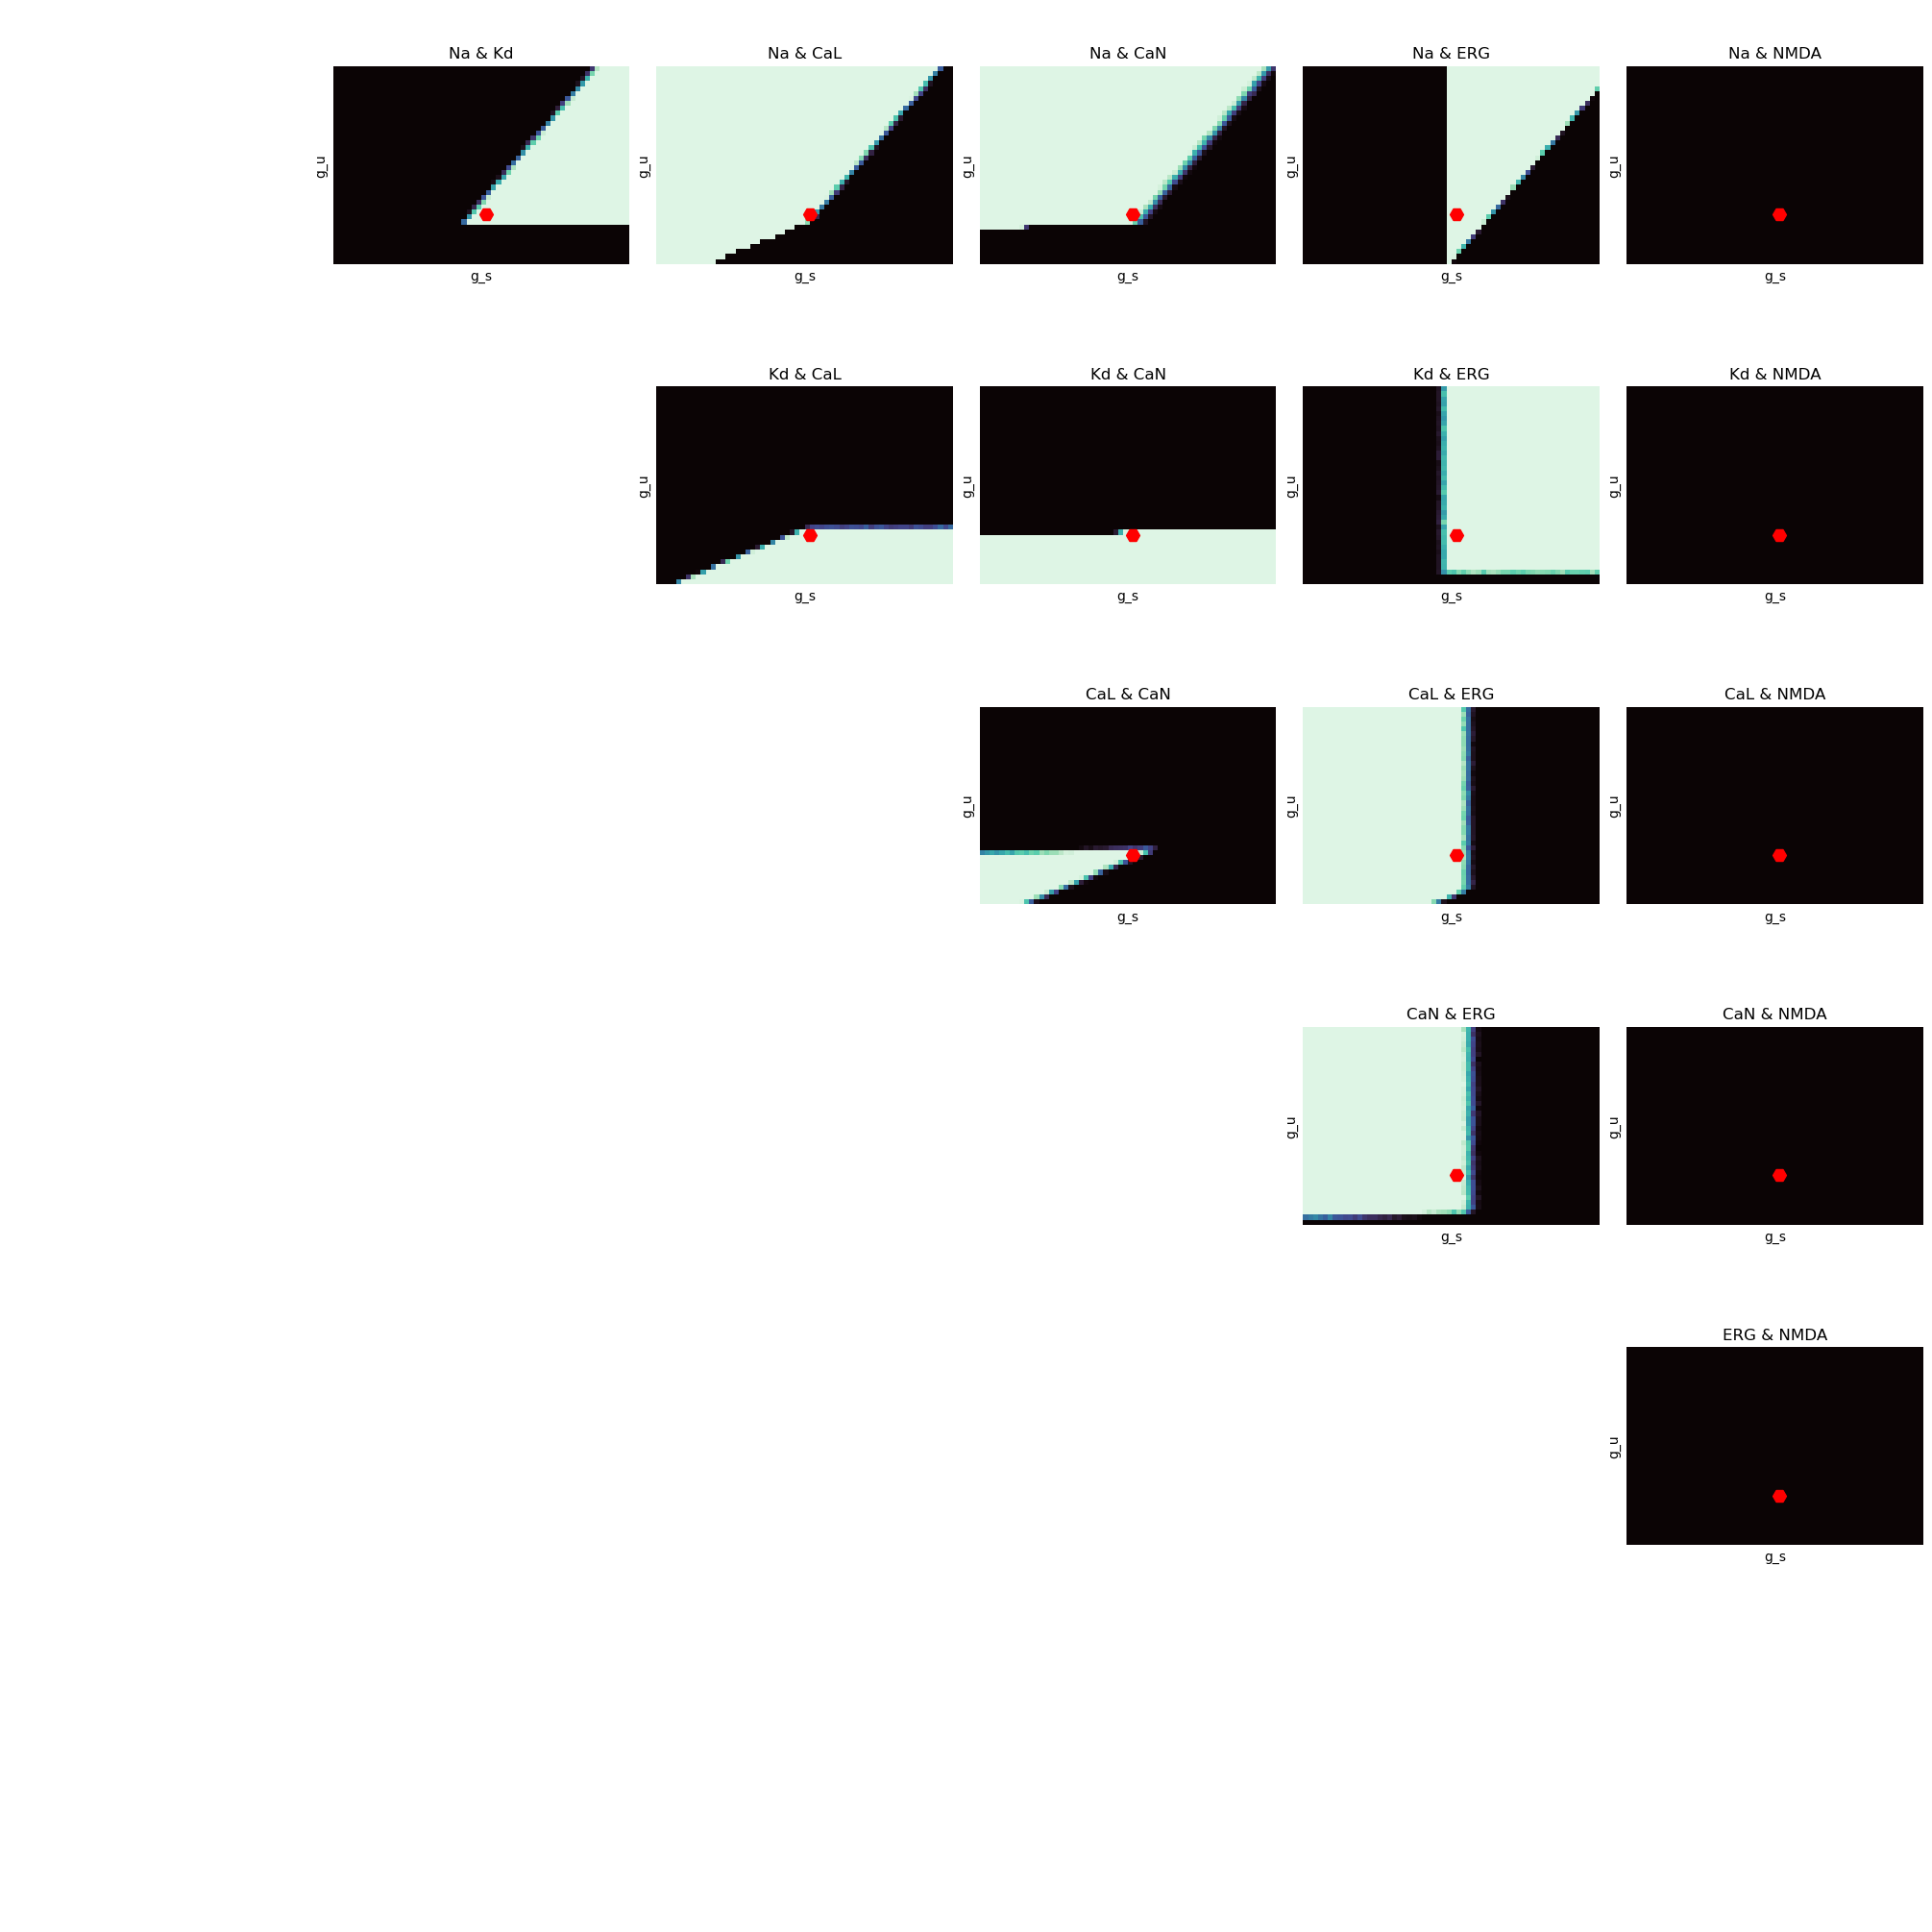

In [8]:
from da import generate_neuromodulated_population, DICs
from joblib import Parallel, delayed

def build_reachability(N_cells, g_s_range, g_u_range, dg, set_to_compensate, epsilon=0.1):
    # we build a uniform grid in the space of g_s and g_u
    g_s_range = np.arange(g_s_range[0], g_s_range[1], dg)
    g_u_range = np.arange(g_u_range[0], g_u_range[1], dg)

    def compute_reachability(i, j):
        pop = generate_neuromodulated_population(N_cells, -55.5, g_s_range[i], g_u_range[j], set_to_compensate=set_to_compensate)

        #cleaning for instabilities is done in the generate_neuromodulated_population function, it removes any negative values
        
        dics = DICs(-55.5, *(pop.T), **get_default_parameters())
        dics = np.array(dics).squeeze()[[1, 2]]  # 2 x N_cells
        residuals = np.linalg.norm(dics - np.array([g_s_range[i], g_u_range[j]]).reshape(2, 1), axis=0)
        return np.sum(residuals < epsilon) / N_cells

    # Parallelize the computation
    results = Parallel(n_jobs=-1)(delayed(compute_reachability)(i, j) for i in range(len(g_s_range)) for j in range(len(g_u_range)))

    # Reshape the results into a 2D array
    reachability = np.array(results).reshape(len(g_s_range), len(g_u_range))

    return reachability

def plot_reachability(reachability, g_s_range, g_u_range, dg, set_to_compensate, save=False):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.heatmap(reachability.T, xticklabels=False, 
                yticklabels=False, cmap="mako", ax=ax, square=True, vmin=0, vmax=1)
    ax.invert_yaxis()
    # add a scatter point at g_s = 4 and g_u = 5
    ax.scatter((0.5 - g_s_range[0]) / dg, (5 - g_u_range[0]) / dg, color='red', s=100, marker='H')
    ax.set_xticks(np.arange(0, len(g_s_range), 10))
    ax.set_yticks(np.arange(0, len(g_u_range), 10))
    ax.set_xticklabels([f"{g_s:.1f}" for g_s in g_s_range[::10]])
    ax.set_yticklabels([f"{g_u:.1f}" for g_u in g_u_range[::10]])
    ax.set_xlabel("g_s")
    ax.set_ylabel("g_u")
    ax.set_title(f"Reachability (Compensating: {', '.join(set_to_compensate)})")

    if save:
        # save as svg
        fig.savefig(f"figures/da_reachability_{set_to_compensate[0]}_{set_to_compensate[1]}.svg", format='svg')

    return fig, ax

g_s_range = [-15, 15]
g_u_range = [0., 20]
dg = 0.5
N_cells = 100

list_of_vars = ['Na', 'Kd', 'CaL', 'CaN', 'ERG', 'NMDA']

fig, axes = plt.subplots(len(list_of_vars), len(list_of_vars), figsize=(20, 20), constrained_layout=True)

for i in range(0, len(list_of_vars)):
    for j in range(i+1, len(list_of_vars)):
        set_to_compensate = [list_of_vars[i], list_of_vars[j]]
        reachability = build_reachability(N_cells, g_s_range, g_u_range, dg, set_to_compensate)
        ax = axes[i, j]
        sns.heatmap(reachability.T, xticklabels=False, yticklabels=False, cmap="mako", ax=ax, square=True, vmin=0, vmax=1, cbar=False, rasterized=True)
        ax.invert_yaxis()
        ax.scatter((0.5 - g_s_range[0]) / dg, (5. - g_u_range[0]) / dg, color='red', s=100, marker='H')
        ax.set_title(f"{list_of_vars[i]} & {list_of_vars[j]}")
        ax.set_xlabel("g_s")
        ax.set_ylabel("g_u")

# Hide unused subplots
for i in range(len(list_of_vars)):
    for j in range(i+1):
        axes[i, j].axis('off')

# Save the combined figure
fig.savefig("figures/da_reachability_combined.svg", format='svg')
plt.show()